<a href="https://colab.research.google.com/github/AlirezaAhadipour/Micrograd/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install micrograd

In [2]:
from micrograd.engine import Value

### Example

In [3]:
a = Value(-4.0)
b = Value(2.0)

c = a + b
d = (a * b) + (b ** 3)
c += c + 1
c += 1 + c + (-a)
d += (d * 2) + (b + a).relu()
d += (3 * d) + (b - a).relu()
e = c - d
f = e ** 2
g = f / 2.0
g += 10.0 / f

print(f'Outcome of forward pass: \n {g.data: .4f}')
g.backward()
print(f'Numerical value of dg/da: \n {a.grad: .4f}')
print(f'Numerical value of dg/db: \n {b.grad: .4f}')


Outcome of forward pass: 
  24.7041
Numerical value of dg/da: 
  138.8338
Numerical value of dg/db: 
  645.5773


# Micrograd from scratch

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class Value():
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0   # initialize the gradient at 0
    self._backward = lambda: None   # empty function
    self._prev = set(_children)   # previous value(s)
    self._op = _op   # previous operation
    self.label = label

  def __repr__(self):
    return f'value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), 'Only supporting int/float powers'
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):   # other * self
    return self * other

  def __truediv__(self, other) :   # self / other
    return self * (other ** -1)

  def __neg__(self):   # - self
    return self * -1

  def __sub__(self, other):   # self - other
    return self + (-other)

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1
    for node in reversed(topo):
      node._backward()


In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

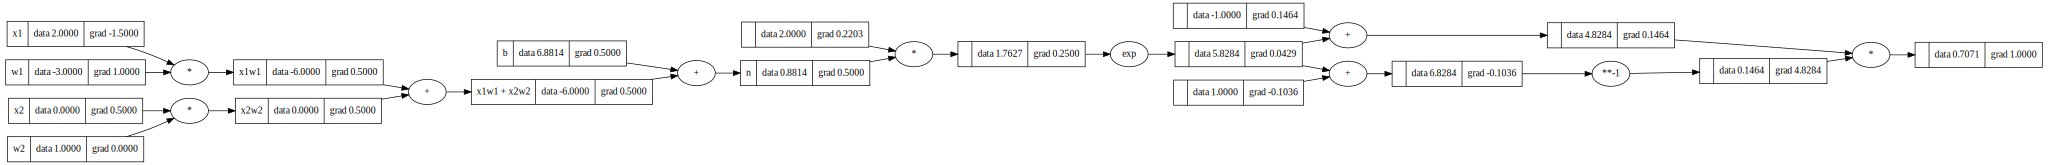

In [7]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'
e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.backward()
draw_dot(o)

### PyTorch

In [8]:
import torch

In [9]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('out', o.data.item())   # o.item() works the same

o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

out 0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
## Define MLP (Multi-Layer Perceptron)
import random

# Define a single neuron
class Neuron:
  def __init__(self, n_in):   # takes the number of inputs to the neuron and initializes them with some random value
    self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer():
  def __init__(self, n_in, n_out):
    self.neurons = [Neuron(n_in) for _ in range(n_out)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self, n_in, n_outs):
    sz = [n_in] + n_outs
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [11]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

value(data=-0.8665828324247837)

In [12]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, 1, -1]
]

ys = [1, -1, -1, 1]   # desired targets

### Training loop

In [13]:
for k in range(100):

  # forward pass
  y_pred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)], Value(0))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 5.384006689662268
1 1.5569305251890189
2 0.737495878598123
3 0.4653905570137833
4 0.31821845866396137
5 0.23362715757405322
6 0.18108250586792762
7 0.14613912396924916
8 0.12158713830836401
9 0.10356346010126814
10 0.0898592481708057
11 0.07913804746426685
12 0.07055143281139778
13 0.06353843550887632
14 0.05771509937831394
15 0.05281072735797714
16 0.04862953227259884
17 0.04502672316791095
18 0.04189311472549138
19 0.039144942194771874
20 0.03671695258753738
21 0.03455761385824132
22 0.032625726517607985
23 0.030887984127951594
24 0.029317188451654527
25 0.027890924324375815
26 0.026590562616151787
27 0.025400500816937076
28 0.02430757807373168
29 0.0233006199088567
30 0.022370080456075633
31 0.02150775881555297
32 0.020706572304692618
33 0.01996037378929479
34 0.019263803461869806
35 0.01861216775717245
36 0.01800133980852523
37 0.0174276771245233
38 0.016887953124581745
39 0.01637929989848598
40 0.015899160110287417
41 0.01544524639425675
42 0.015015506921959736
43 0.014608096078

In [14]:
y_pred

[value(data=0.9518869012795539),
 value(data=-0.9797754257769461),
 value(data=-0.9545117959076697),
 value(data=0.9707003229356715)]